## What is DBSCAN?

DBSCAN stands for **Density-Based Spatial Clustering of Applications with Noise**.  
Unlike K-Means (which we covered in part 1), which requires you to set the number of clusters upfront, DBSCAN groups together points that are in **dense regions** and marks points in sparse regions as **noise** (outliers).  


## DBSCAN Algorithm

**Goal:** find clusters as contiguous regions of high density and label sparse points as noise.

**Inputs**
- `eps`: neighborhood radius
- `min_samples`: minimum number of neighbors within `eps` to qualify as a core point
- `X`: dataset

**Point types**
- **Core**: at least `min_samples` neighbors within `eps`
- **Border**: not core, but within `eps` of a core point
- **Noise**: neither core nor border (labeled `-1`)

### The Rules
1. Pick a point and look around it within distance `eps`.  
2. If it has enough neighbors (at least `min_samples`), it becomes a **core point** and starts a cluster.  
3. Any points close to a core point get pulled into that cluster.  
   - If they don’t have enough neighbors themselves, they’re called **border points**.  
4. Points that don’t belong anywhere are labeled **noise**.  

### The Output
- Every point is either in a cluster (0, 1, 2, …) or marked as noise (`-1`).  
- You don’t need to set the number of clusters ahead of time.  
- DBSCAN is good at finding oddly shaped clusters and spotting outliers, but it’s sensitive
- Sensitive to `eps` and `min_samples`. One global `eps` struggles if clusters have very different densities.


First, let's import our necessary dependencies.

In [427]:
# Plotting, math, and dataframes
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Python's core machine learning library
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# For graphics later
import imageio
from IPython.display import Image


In [ ]:
# Load data from dataset folder
df = pd.read_csv("dataset/Mall_Customers.csv")

df.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [429]:
X = df[["Annual Income (k$)", "Spending Score (1-100)"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


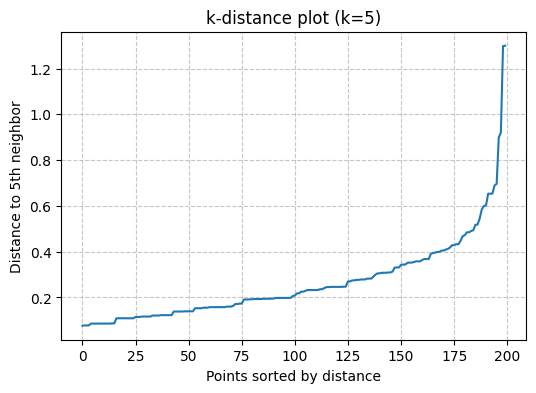

In [ ]:
min_samples = 5 

# k-distance plot
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_dists = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dists)
plt.title(f"k-distance plot (k={min_samples})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_samples}th neighbor")
plt.grid(True, linestyle="--", alpha=0.7) 
plt.show()


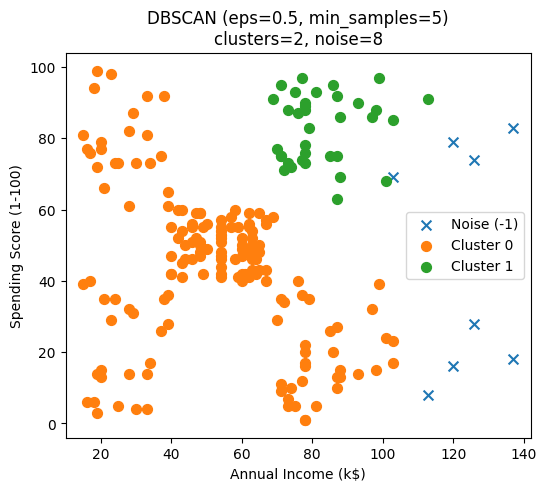

In [ ]:
eps = 0.5
min_samples = 5

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

unique_labels = np.unique(labels)

# Count clusters (excluding noise) and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int(np.sum(labels == -1))

# Plot clusters with fixed axis limits
plt.figure(figsize=(6,5))
for c in unique_labels:
    m = labels == c
    if c == -1:
        plt.scatter(X[m,0], X[m,1], s=50, marker="x", label="Noise (-1)")
    else:
        plt.scatter(X[m,0], X[m,1], s=50, label=f"Cluster {c}")

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})\nclusters={n_clusters}, noise={n_noise}")
plt.legend()

# Keep x and y axis ranges consistent
plt.xlim(X[:,0].min() - 5, X[:,0].max() + 5)
plt.ylim(X[:,1].min() - 5, X[:,1].max() + 5)

plt.show()


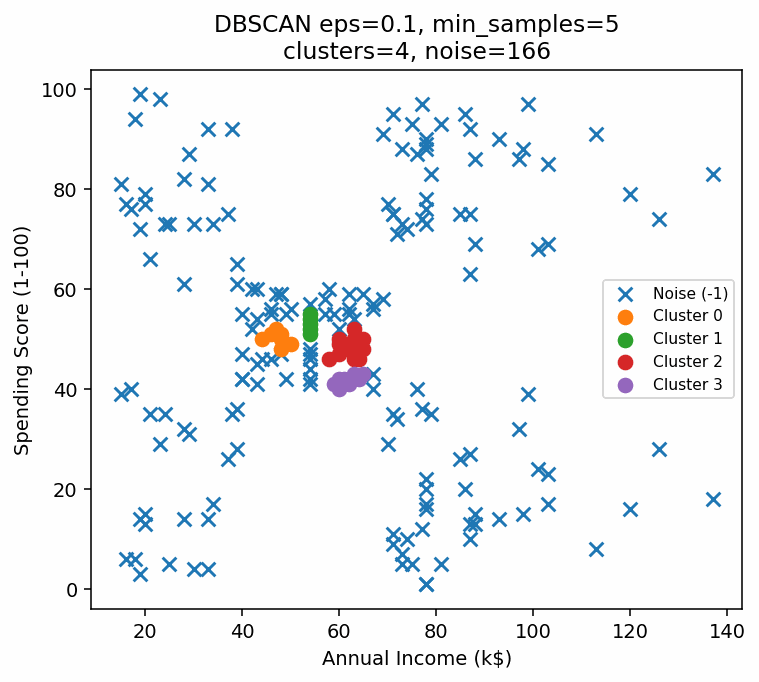

In [ ]:
# Set of epsilon values
eps_values = [.1, 0.3, .35, 0.4, .45, 0.5, .55, 0.6, 0.8]

snapshots = []
os.makedirs("dbscan_eps_frames", exist_ok=True)

for e in eps_values:
    db_tmp = DBSCAN(eps=e, min_samples=min_samples)
    labels_tmp = db_tmp.fit_predict(X_scaled)
    uniq = np.unique(labels_tmp)

    # Metrics for the frame
    n_clusters = len(set(labels_tmp)) - (1 if -1 in labels_tmp else 0)
    n_noise = int(np.sum(labels_tmp == -1))

    plt.figure(figsize=(6,5))
    for c in uniq:
        m = labels_tmp == c
        if c == -1:
            plt.scatter(X[m, 0], X[m, 1], s=50, marker="x", label="Noise (-1)")
        else:
            plt.scatter(X[m, 0], X[m, 1], s=50, label=f"Cluster {c}")

    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
    plt.title(f"DBSCAN eps={e}, min_samples={min_samples}\nclusters={n_clusters}, noise={n_noise}")
    plt.legend(loc="best", fontsize=8)

    fname = f"dbscan_eps_frames/eps_{str(e).replace('.','_')}.png"
    plt.savefig(fname, dpi=140, bbox_inches="tight")
    plt.close()
    snapshots.append(fname)

gif_path = "dbscan_eps.gif"
with imageio.get_writer(gif_path, mode="I", duration=3000, loop=0) as writer: 
    for f in snapshots:
        writer.append_data(imageio.v2.imread(f))

Image(filename=gif_path)


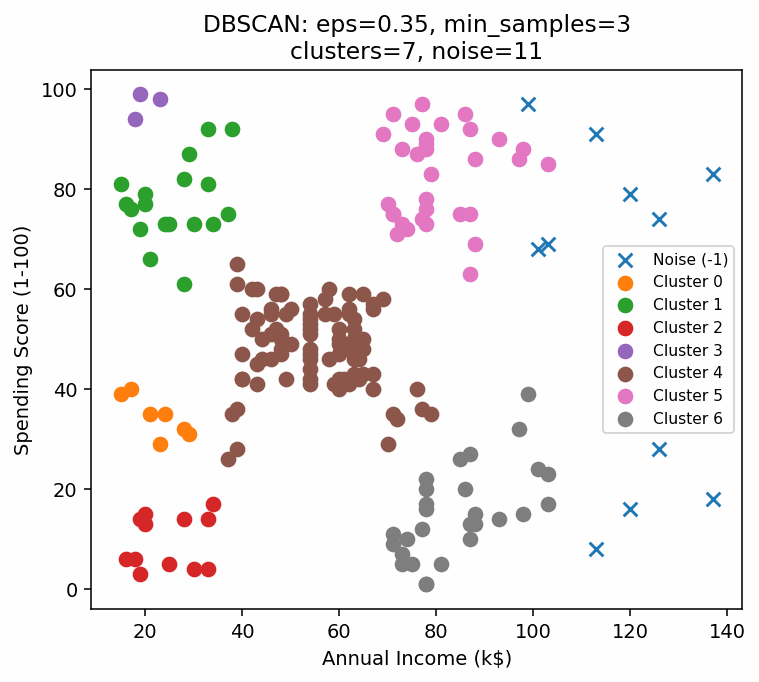

In [ ]:
ms_values = [3, 4, 5, 6, 8, 10, 12, 15]
frame_dir = "dbscan_min_samples_frames"
os.makedirs(frame_dir, exist_ok=True)
frames = []
eps = .35

for ms in ms_values:
    db = DBSCAN(eps, min_samples=ms)
    labels_tmp = db.fit_predict(X_scaled)
    uniq = np.unique(labels_tmp)

    plt.figure(figsize=(6,5))
    for c in uniq:
        mask = labels_tmp == c
        if c == -1:
            plt.scatter(X[mask,0], X[mask,1], s=50, marker="x", label="Noise (-1)")
        else:
            plt.scatter(X[mask,0], X[mask,1], s=50, label=f"Cluster {c}")
    n_clusters = len(set(labels_tmp)) - (1 if -1 in labels_tmp else 0)
    n_noise = np.sum(labels_tmp == -1)
    plt.title(f"DBSCAN: eps={eps}, min_samples={ms}\nclusters={n_clusters}, noise={n_noise}")
    plt.xlabel("Annual Income (k$)"); plt.ylabel("Spending Score (1-100)")
    plt.legend(loc="best", fontsize=8)

    fname = f"{frame_dir}/ms_{ms}.png"
    plt.savefig(fname, dpi=140, bbox_inches="tight")
    plt.close()
    frames.append(fname)

gif_path = "dbscan_min_samples.gif"
with imageio.get_writer(gif_path, mode="I", duration=3000, loop=0) as w: 
    for f in frames:
        w.append_data(imageio.v2.imread(f))

Image(filename=gif_path)
